## Import Libraries

Import all the required Libraries

In [1]:
import os
import pandas as pd

import re

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.extmath import density
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

from sklearn.decomposition import PCA

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from collections import Counter

Using TensorFlow backend.
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# Ablation Experiment (takes 15% of Total Data if ablation is true)
ablation = False
ablation_ratio = 0.6

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000
# Percentile of Padding to use with Tokenized words
pad_percentile = 50

# Use Keras Tokenizer
use_tokenizer = False
# Use TF IDF Vectorizer
use_tf_idf = True

# Text Column name
text_col = 'lower_text'

# How many PCA Components to consider for modelling
pca_components = 700

# Seed
numpy_seed = 478
seed = 7
# Number of Splits
n_splits = 10
# Scoring Criteria
scoring = 'neg_log_loss'

# if Debug is True, loads Subsequent Dataframes from Disk.
debug = False

train_run = True

## Create Train and Test DF

Create Training and Testing Data Frames

In [4]:
# TODO: Automate it to take path based on OS
#ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants' # Mac Directory Path
ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants' # Linux Directory Path

TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')

SUB = os.path.join(ROOT_DIR, r'sample_submission.csv')

In [5]:
# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df

In [6]:
# Map target variable to number
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

# Util Functions

Some Utility Functions 

In [7]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [8]:
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [9]:
def get_tf_idf(train_df, test_df):
    """
        Get the TF IDF Vector representation for Train and Test data frame
        
        Creates the TF-IDF Vector, Fit on Training data and transform both training and test data frames
        Also, returns feature names for creating a Dataframe later
    """
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names()

In [10]:
def lemmatize(words):
    """
        Break a Sentence into words, remove Stop words keeping only alphabet and numbers, remove
        punctuations, comma etc. and at the end Lemmatize the words.
    """
    tokenized_words = nltk.word_tokenize(words)
    
    # Remove Stop words
    words = [word for word in tokenized_words if word.lower() not in stop_words]
    
    # Remove Digits, Keep only Alpha Numeric words
    words = [word for word in words if word.isalnum() and not word.isdigit()]

    # Lemmatize based on root word
    pos_tags = nltk.pos_tag(words)
    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tags])

In [11]:
def add_features(df):
    """
        Add few extra features to the Data Frame
        
        text: convert to string
        lower_text: lowers the text
        total_length: length of the document
        capitals: number of capitals in document
        caps_vs_length: ratio of capital words to total length
        num_words: number of words in document.
        num_unique_words: number of unique words in document
        words_vs_unique: number of unique words in document
        document_type: whether the docoment is pdf, doc or docx
    """
    df['text'] = df['text'].apply(lambda x:str(x))
    df["lower_text"] = df["text"].apply(lambda x: x.lower())
    df['total_length'] = df['lower_text'].apply(len)
    df['capitals'] = df['lower_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.text.str.count('\S+')
    df['num_unique_words'] = df['lower_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    df['document_type'] = df['document_name'].apply(lambda val: val.split(".")[-1])
    
    return df

In [12]:
%%time

def get_top_words_list(df):
    word_list = []

    df['lower_text'].map(lambda row: word_list.extend(row.split()))

    counter_df = pd.DataFrame.from_dict(Counter(word_list), orient='index').reset_index()

    counter_df.columns = ['word', 'frequency']

    return counter_df.sort_values(by = 'frequency', ascending = False)

def get_top_words(df):
    # Segregated Positive and Negative classes
    top_counter_df_no = get_top_words_list(df[df.is_fitara == 0])
    top_counter_df_yes = get_top_words_list(df[df.is_fitara == 1])
    
    # Fetch Words in Negative class, which are not in Positive class
    exclusive_no = set(top_counter_df_no['word'].values) - set(top_counter_df_yes['word'].values)
    # Fetch Words in Positive class, which are not in Negative class
    exclusive_yes = set(top_counter_df_yes['word'].values) - set(top_counter_df_no['word'].values)
    
    # English Words Corpus
    english_words = set(nltk.corpus.words.words())
    
    # Keep valid english words only, remove random words
    exclusive_no = [word for word in exclusive_no if word in english_words]
    exclusive_yes = [word for word in exclusive_yes if word in english_words]
    
    # Get the Frequency of corresponding words from Original Dataframe
    exclusive_no_df = top_counter_df_no[top_counter_df_no['word'].isin(exclusive_no)]
    exclusive_yes_df = top_counter_df_yes[top_counter_df_yes['word'].isin(exclusive_yes)]
    
    return exclusive_no_df, exclusive_yes_df

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [13]:
def add_percentile_features(df):
    df['percentile_99'] = df[text_col].apply(get_positive_words_99)
    df['percentile_95'] = df[text_col].apply(get_positive_words_95)
    df['percentile_90'] = df[text_col].apply(get_positive_words_90)
    df['percentile_85'] = df[text_col].apply(get_positive_words_85)
    df['percentile_80'] = df[text_col].apply(get_positive_words_80)
    df['percentile_75'] = df[text_col].apply(get_positive_words_75)
    df['percentile_70'] = df[text_col].apply(get_positive_words_70)
    df['percentile_65'] = df[text_col].apply(get_positive_words_65)
    df['percentile_60'] = df[text_col].apply(get_positive_words_60)
    df['percentile_55'] = df[text_col].apply(get_positive_words_55)
    df['percentile_50'] = df[text_col].apply(get_positive_words_50)
    
    return df

## Add Basic Derived Features

In [14]:
# Add derived features on Train dataframe
train_df = add_features(train_df)
test_df = add_features(test_df)

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

# English Stop Words list
stop_words = set(nltk.corpus.stopwords.words('english'))

# Create a Tag Dictionary, Default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Get a Lemmatizer
lemma = WordNetLemmatizer()

In [16]:
%%time

# Caution: will take time to lemmatize whole Data
train_df[text_col] = train_df[text_col].apply(lemmatize)
test_df[text_col] = test_df[text_col].apply(lemmatize)

CPU times: user 5min 2s, sys: 435 ms, total: 5min 2s
Wall time: 5min 3s


In [17]:


# Since, we have fetched document type from name and lower case text from text, we could safely remove these two columns
to_drop = ['text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

In [18]:
train_df.to_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
test_df.to_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

In [19]:
if debug:
    train_df = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
    test_df = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [20]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

In [21]:
# Plot top 25 words 
#plt.figure(figsize=(20,12))
#sns.barplot(x = 'word', y = 'frequency', data = exclusive_no_df.head(25))
#plt.plot()
#plt.figure(figsize=(20,12))
#sns.barplot(x = 'word', y = 'frequency', data = exclusive_yes_df.head(25))
#plt.plot()

### Handle Categorical Variables

In [22]:
# Create dummies
train_df = pd.concat([train_df, pd.get_dummies(train_df['document_type'])], axis=1)
train_df.drop(['document_type'], axis=1, inplace=True)

# Create dummies
test_df = pd.concat([test_df, pd.get_dummies(test_df['document_type'])], axis=1)
test_df.drop(['document_type'], axis=1, inplace=True)

### Ablation
If ablation is true, use only certain percentage of data for calculations

In [23]:
if ablation:
    train_df_no = train_df[train_df.is_fitara == 0]
    train_df_yes = train_df[train_df.is_fitara == 1]

    # Get 15% of total Records for Ablation
    train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation_ratio)]
    train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation_ratio)]
    
    # Shuffle rows and reset index
    train_df = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

### Train Test Split
Split into Test and training data sets

In [24]:
X = train_df.drop(['document_name', 'is_fitara'], axis=1)
y = train_df['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Add Percentile Features

In [25]:
#exclusive_no_df, exclusive_yes_df = get_top_words(pd.concat([X_train, y_train], axis=1))
#init_word_dict(train_df)

In [26]:
#exclusive_yes_df_99 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.99)]
#exclusive_yes_df_95 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.95)]
#exclusive_yes_df_90 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.90)]
#exclusive_yes_df_85 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.85)]
#exclusive_yes_df_80 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.80)]
#exclusive_yes_df_75 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.75)]
#exclusive_yes_df_70 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.70)]
#exclusive_yes_df_65 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.65)]
#exclusive_yes_df_60 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.60)]
#exclusive_yes_df_55 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.55)]
#exclusive_yes_df_50 = exclusive_yes_df[exclusive_yes_df.frequency >= exclusive_yes_df['frequency'].quantile(0.50)]

def init_word_dict(df):
    df2 = get_top_words_list(df)
    
    word_dict = dict(zip([word for word in df2.word], 
                         [re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE) for word in df2.word]))

def findWholeWord(word):
    return re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE).search

def get_positive_words(text, df):
    return int(any([findWholeWord(word)(text) != None for word in df['word']]))

def get_positive_words_99(text):
    return get_positive_words(text, exclusive_yes_df_99)

def get_positive_words_95(text):
    return get_positive_words(text, exclusive_yes_df_95)

def get_positive_words_90(text):
    return get_positive_words(text, exclusive_yes_df_90)

def get_positive_words_85(text):
    return get_positive_words(text, exclusive_yes_df_85)

def get_positive_words_80(text):
    return get_positive_words(text, exclusive_yes_df_80)

def get_positive_words_75(text):
    return get_positive_words(text, exclusive_yes_df_75)

def get_positive_words_70(text):
    return get_positive_words(text, exclusive_yes_df_70)

def get_positive_words_65(text):
    return get_positive_words(text, exclusive_yes_df_65)

def get_positive_words_60(text):
    return get_positive_words(text, exclusive_yes_df_60)

def get_positive_words_55(text):
    return get_positive_words(text, exclusive_yes_df_55)

def get_positive_words_50(text):
    return get_positive_words(text, exclusive_yes_df_50)


In [27]:
%%time

#X_train = add_percentile_features(X_train)
#X_test = add_percentile_features(X_test)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


### TF IDF
Create TF IDF Vector representation for Train and Test datasets

In [28]:
if use_tf_idf:
    X_train_tf, X_test_tf, feature_names = get_tf_idf(X_train[text_col], X_test[text_col])

    X_train_df = pd.DataFrame(X_train_tf.toarray(), columns = feature_names, index = X_train.index)
    X_test_df = pd.DataFrame(X_test_tf.toarray(), columns = feature_names, index = X_test.index)

    X_train = pd.concat([X_train, X_train_df], axis=1)
    X_test = pd.concat([X_test, X_test_df], axis=1)

    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

### Tokenize the Strings
Tokenize the words into numbers

In [29]:
if use_tokenizer:
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train[text_col]))
    X_train[text_col] = tokenizer.texts_to_sequences(X_train[text_col])
    X_test[text_col] = tokenizer.texts_to_sequences(X_test[text_col])

### Pad the sentences 
if tokenizing the words, needs to handle length as well. All the vectors needs to be same length, so pad the ones that are shorter. <br/>

In [30]:
if use_tokenizer:
    # Find Length of all rows, take a number 50 percentile number
    train_max_len = np.percentile(X_train[text_col].apply(len), pad_percentile)
    test_max_len = np.percentile(X_test[text_col].apply(len), pad_percentile)

    # Get the maximum length
    max_len = int(test_max_len if train_max_len < test_max_len else train_max_len)

    # Pad the Sentences
    X_train_temp = pd.DataFrame(pad_sequences(X_train[text_col], maxlen=max_len), index = X_train.index)
    X_test_temp = pd.DataFrame(pad_sequences(X_test[text_col], maxlen=max_len), index = X_test.index)

    # Remove Existing DF
    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

    # Create new DF
    X_train = pd.concat([X_train_temp, X_train], axis = 1)
    X_test = pd.concat([X_test_temp, X_test], axis = 1)

### Standard Scaler Transformation

In [31]:
# Scale the columns
scaler = StandardScaler()

if use_tokenizer:
    cols = X_train.columns
elif use_tf_idf:
    cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [32]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'))
X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'))

In [47]:
if True:
    X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'), index_col='Unnamed: 0')
    X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'), index_col='Unnamed: 0')

### Principle Component Analysis

In [48]:
standard_columns = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique', 
        'doc', 'docx', 'pdf']
    #, 'percentile_99', 'percentile_95', 'percentile_90',
       #'percentile_85', 'percentile_80', 'percentile_75', 'percentile_70',
       #'percentile_65', 'percentile_60', 'percentile_55', 'percentile_50']

cols = X_train.columns[len(standard_columns):]

print(cols)
pca = PCA(n_components = 350)

pca.fit(X_train[cols])

X_train_pca = pd.DataFrame(pca.transform(X_train[cols]))
X_test_pca = pd.DataFrame(pca.transform(X_test[cols]))

X_train_pca.index = X_train.index
X_test_pca.index = X_test.index

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

Index(['0001a', '0001b', '0004a', '0010000f', '0011mm', '0015mm', '001w',
       '003a1000', '004d', '004kc0434ty2',
       ...
       'ﬂushedi', 'ﬂushing', 'ﬂute', 'ﬂuw', 'ﬂwsﬂwwwwdd', 'ﬂxis', 'ﬂynlzm',
       'ﬂzi', 'ﬂﬁoﬂome', 'ﬂﬂ'],
      dtype='object', length=44303)
Variance Explained by Model is 0.9157498317063709


In [49]:
# Remove Old Columns
X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

# Append PCA Columns
X_train = pd.concat([X_train, X_train_pca], axis=1)
X_test = pd.concat([X_test, X_test_pca], axis=1)

In [50]:
# Save PCA Dataframe to Disk

X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pca_2.csv'))
y_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_label_pca_2.csv'))

X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pca.csv'))
y_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_label_pca.csv'))

In [51]:
if debug:
    X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pca.csv'), index_col='Unnamed: 0')
    y_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_label_pca.csv'), header=None, index_col='Unnamed: 0')

    X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pca.csv'), index_col='Unnamed: 0')
    y_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_label_pca.csv'), header=None, index_col='Unnamed: 0')

### Model Building
First Try fitting a Simple Neural Network for benchmark

Let's check cross validation score for different algorithms on training Data

XGB :: -0.352353 ( +- 0.061139) 
 Log Loss : 0.336623
 Accuracy : 86.910000

GBC :: -0.357429 ( +- 0.070438) 
 Log Loss : 0.331414
 Accuracy : 87.960000



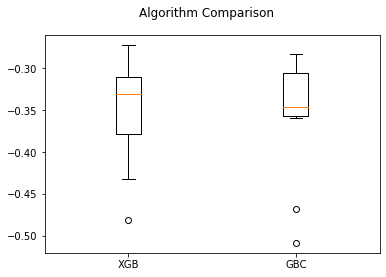

In [67]:
"""
If we use sklearn.metrics.log_loss standalone, i.e. log_loss(y_true,y_pred), 
it generates a positive score -- the smaller the score, the better the performance.

However, if we use 'neg_log_loss' as a scoring scheme as in 'cross_val_score", 
the score is negative -- the bigger the score, the better the performance.
"""

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict


estimators = []

#estimators.append(('LR', LogisticRegression()))
#estimators.append(('NB', BernoulliNB(alpha=.01)))
#estimators.append(('LDA', LinearDiscriminantAnalysis()))
#estimators.append(('KNN', KNeighborsClassifier()))
#estimators.append(('TREE', DecisionTreeClassifier()))
#estimators.append(('CART', RandomForestClassifier(n_estimators=100)))
#estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', SVC(probability=True)))
estimators.append(('XGB', XGBClassifier()))
estimators.append(('GBC', GradientBoostingClassifier(n_estimators=100)))

# evaluate each model in turn
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_log_loss')
    #cv_results = model_selection.cross_val_predict(model, X_train, y_train, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    
    model.fit(X_train, y_train)
    
    log_loss = metrics.log_loss(y_test, model.predict_proba(X_test))
    accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    msg = "%s :: %f ( +- %f) \n Log Loss : %f\n Accuracy : %f\n" % (name, cv_results.mean(), cv_results.std(), log_loss, round(accuracy*100, 2))
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [68]:

pd.DataFrame(metrics.confusion_matrix(y_test.values, estimators[1][1].predict(X_test)), 
             columns = ["Prediction No","Prediction Yes"], index=["Actual No", "Actual Yes"])

#print(metrics.accuracy_score(y_test.values, estimators[2][1].predict(X_test)))
#print(metrics.log_loss(y_test.values, estimators[4][1].predict_proba(X_test)))
#math.exp(-metrics.log_loss(y_test.values, estimators[5][1].predict_proba(X_test)))

#y_pred = estimators[2][1].predict(X_test)
#metrics.roc_curve(y_test.values, y_pred)
#estimators[2][1].predict_proba(X_test)

,Prediction No,Prediction Yes
Actual No,132,6
Actual Yes,17,36


In [69]:
# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')

kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
cv_results = cross_val_score(ensemble, X_train.values, y_train, cv=kfold, scoring='neg_log_loss', n_jobs=-1) 

print("%s: %f (+/- %f)" % ("Ensemble", cv_results.mean(), cv_results.std()))

ensemble.fit(X_train, y_train)

print(metrics.log_loss(y_test, ensemble.predict_proba(X_test)))
print(metrics.accuracy_score(y_test, ensemble.predict(X_test)))

pd.DataFrame(metrics.confusion_matrix(y_test.values, ensemble.predict(X_test)), 
             columns = ["Prediction No","Prediction Yes"], index=["Actual No", "Actual Yes"])


Ensemble: -0.347761 (+/- 0.063573)
0.3307595809617215
0.8691099476439791


,Prediction No,Prediction Yes
Actual No,131,7
Actual Yes,18,35


In [66]:
%%time

clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000, # Very large number
    seed=7,
    reg_alpha=5,
    eval_metric='auc',
    tree_method='gpu_hist'
)
clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train)],
    early_stopping_rounds=50,
    verbose=50
)

print(metrics.log_loss(y_test, clf.predict_proba(X_test)))
pd.DataFrame(metrics.confusion_matrix(y_test.values, ensemble.predict(X_test)), 
             columns = ["Prediction No","Prediction Yes"], index=["Actual No", "Actual Yes"])

[0]	validation_0-auc:0.813034
Will train until validation_0-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.924006
[100]	validation_0-auc:0.930418
[150]	validation_0-auc:0.943522
[200]	validation_0-auc:0.955701
[250]	validation_0-auc:0.964509
[300]	validation_0-auc:0.972834
[350]	validation_0-auc:0.979092
[400]	validation_0-auc:0.984009
[450]	validation_0-auc:0.987817
[500]	validation_0-auc:0.990634
[550]	validation_0-auc:0.992909
[600]	validation_0-auc:0.994425
[650]	validation_0-auc:0.995833
[700]	validation_0-auc:0.996908
[750]	validation_0-auc:0.99775
[800]	validation_0-auc:0.998308
[850]	validation_0-auc:0.998742
[900]	validation_0-auc:0.999092
[950]	validation_0-auc:0.999317
[1000]	validation_0-auc:0.999508
[1050]	validation_0-auc:0.999625
[1100]	validation_0-auc:0.999758
[1150]	validation_0-auc:0.999833
[1200]	validation_0-auc:0.999858
[1250]	validation_0-auc:0.9999
[1300]	validation_0-auc:0.99995
[1350]	validation_0-auc:0.999967
[1400]	validation_0-auc:0.999975
Stoppi

,Prediction No,Prediction Yes
Actual No,131,7
Actual Yes,19,34


# Create Submission File

In [101]:
%%time
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df

train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

# Add derived features on Train dataframe
train_df = add_features(train_df)
test_df = add_features(test_df)

train_df[text_col] = train_df[text_col].apply(lemmatize)
test_df[text_col] = test_df[text_col].apply(lemmatize)

to_drop = ['text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

# Create dummies
train_df = pd.concat([train_df, pd.get_dummies(train_df['document_type'], prefix='document_type')], axis=1)
train_df.drop(['document_type'], axis=1, inplace=True)

# Create dummies
test_df = pd.concat([test_df, pd.get_dummies(test_df['document_type'], prefix='document_type')], axis=1)
test_df.drop(['document_type'], axis=1, inplace=True)

X_train = train_df.drop(['document_name', 'is_fitara'], axis=1)
y_train = train_df['is_fitara']

X_test = test_df.drop(['document_name'], axis=1)

X_train_tf, X_test_tf, feature_names = get_tf_idf(X_train[text_col], X_test[text_col])

X_train_df = pd.DataFrame(X_train_tf.toarray(), columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(X_test_tf.toarray(), columns = feature_names, index = X_test.index)

X_train = pd.concat([X_train, X_train_df], axis=1)
X_test = pd.concat([X_test, X_test_df], axis=1)

X_train.drop([text_col], axis=1, inplace=True)
X_test.drop([text_col], axis=1, inplace=True)

CPU times: user 5min 18s, sys: 386 ms, total: 5min 18s
Wall time: 5min 18s


In [71]:
# Save PCA Dataframe to Disk

X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_X.csv'))
y_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_label_X.csv'))

X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_X.csv'))

In [102]:
# Scale the columns
scaler = StandardScaler()

# Scale Features
cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique', 
'document_type_doc', 'document_type_docx', 'document_type_pdf']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [73]:
"""
# PCA
columns = X_train.columns[len(cols):]

pca = PCA(n_components = pca_components)

pca.fit(X_train[columns])

X_train_pca = pd.DataFrame(pca.transform(X_train[columns]))
X_test_pca = pd.DataFrame(pca.transform(X_test[columns]))

X_train_pca.index = X_train.index
X_test_pca.index = X_test.index

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

# Remove Old Columns
X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)

# Append PCA Columns
X_train = pd.concat([X_train, X_train_pca], axis=1)
X_test = pd.concat([X_test, X_test_pca], axis=1)
"""

Variance Explained by Model is 0.9962055047582821


LR :: -0.393002 ( +- 0.035955) 

XGB :: -0.316945 ( +- 0.076043) 

GBC :: -0.327429 ( +- 0.068947) 



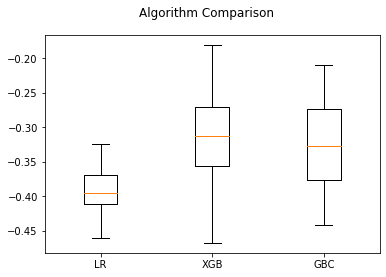

In [111]:
"""
If we use sklearn.metrics.log_loss standalone, i.e. log_loss(y_true,y_pred), 
it generates a positive score -- the smaller the score, the better the performance.

However, if we use 'neg_log_loss' as a scoring scheme as in 'cross_val_score", 
the score is negative -- the bigger the score, the better the performance.
"""

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression


test_estimators = []

test_estimators.append(('LR', LogisticRegression()))
test_estimators.append(('XGB', XGBClassifier()))
test_estimators.append(('GBC', GradientBoostingClassifier(n_estimators=100)))




# evaluate each model in turn
results = []
names = []
for name, model in test_estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_log_loss', n_jobs=6)
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s :: %f ( +- %f) \n" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [95]:
# create the ensemble model
ensemble = VotingClassifier(test_estimators, voting='soft')

kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
cv_results = cross_val_score(test_estimators, X_train.values, y_train, cv=kfold, scoring='neg_log_loss', verbose=2, n_jobs=-1) 

print("%s: %f (+/- %f)" % ("Ensemble", cv_results.mean(), cv_results.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.6s remaining:    5.4s


Ensemble: -0.336650 (+/- 0.051378)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.5s finished


In [86]:
ensemble.fit(X_train, y_train)

In [124]:
X_train

,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,document_type_doc,document_type_docx,document_type_pdf,0001a,...,ﬂushedi,ﬂushing,ﬂute,ﬂuw,ﬂwsﬂwwwwdd,ﬂxis,ﬂynlzm,ﬂzi,ﬂﬁoﬂome,ﬂﬂ
0,1.067873,0.0,0.0,1.010016,1.394817,-1.257795,-0.380899,-0.642434,0.848953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.502823,0.0,0.0,-0.499356,-0.542102,1.040637,-0.380899,-0.642434,0.848953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.515686,0.0,0.0,-0.514483,-0.623054,0.896950,-0.380899,1.556579,-1.177922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.515766,0.0,0.0,-0.513410,-0.620767,0.842674,-0.380899,1.556579,-1.177922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.452354,0.0,0.0,-0.452151,-0.463436,-0.020300,2.625369,-0.642434,-1.177922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,-0.193649,0.0,0.0,-0.327059,0.011304,0.174394,-0.380899,-0.642434,0.848953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,-0.416374,0.0,0.0,-0.424740,-0.431878,-0.334798,-0.380899,-0.642434,0.848953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952,-0.466883,0.0,0.0,-0.469585,-0.514660,0.030004,2.625369,-0.642434,-1.177922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
953,-0.494332,0.0,0.0,-0.490559,-0.566342,0.249175,-0.380899,-0.642434,0.848953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
df = pd.DataFrame(clf.predict_proba(X_test))
#sub = pd.read_csv(SUB)

# Add prediction on Test DF
test_df['pred_fitara'] = round(df.iloc[:, 1], 2)

submission = test_df.loc[:, ['document_name', 'pred_fitara']]
"""
submission = pd.merge(
    sub,
    test_df,  
    on='document_name', 
    how='inner'
).loc[:, ['document_name', 'pred']]

submission.columns = ['document_name', 'pred_fitara']
"""

submission.to_csv(os.path.join(ROOT_DIR, r'submission-3-xgb-without-pca-316945.csv'), index=False)